In [3]:
import pandas as pd
import sys, os
sys.path.append("C:/Users/evank/OneDrive/Python Library/ek")
from utils import utils_ek
from utils.Data_imports import *
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import scipy.stats as sc
import sklearn
import datetime as dt

### Macro Variables for forecasting
Indicators for financial conditions and financial stressto help rpedict equity vol of vol
https://www.financialresearch.gov/financial-stress-index/files/indicators/index.html
https://www.goldmansachs.com/insights/pages/case-for-financial-conditions-index.html


In [4]:
vars = ['ES1 Index', 'TU1 Comdty','TY1 Comdty', 'TWI USSP Index', 'LQD US Equity', 'CL1 Comdty']

In [5]:
data = get_price_data(vars,'20000101')

In [6]:
data = data.droplevel(axis=1,level=1).dropna()

In [7]:
returns = data.pct_change().dropna()
vols = pd.DataFrame()
vols_total = pd.DataFrame()
vols_ewm = pd.DataFrame()
corrs_y = pd.DataFrame()
corrs_m = pd.DataFrame()
corrs_w = pd.DataFrame()
for f in vars:
        vols_total[f + "_Ann_Vol"] = returns[f].rolling(5).std()*51**(1/2)
        vols_ewm[f + "_Ann_Vol"] = returns[f].ewm(10).std()
        corrs_y[f + "_corr_y"] = returns['ES1 Index'].rolling(252).corr(returns[f])
        corrs_m[f + "_corr_m"] = returns['ES1 Index'].rolling(21).corr(returns[f])
        corrs_w[f + "_corr_w"] = returns['ES1 Index'].rolling(5).corr(returns[f])
        vols[f + "_Ann_Vol_Chg"] = np.log(vols_total[f + "_Ann_Vol"]/vols_total[f + "_Ann_Vol"].shift(1))

vols_total['Vix Index']= get_price_data('VIX Index','20000101')
vols_ewm["Vix Index"] = vols_total['Vix Index'].ewm(span=10).mean()
corrs_m['Vix Index_corr_m'] = returns['ES1 Index'].rolling(21).corr(vols_total['Vix Index'])
corrs_w['Vix Index_corr_w'] = returns['ES1 Index'].rolling(5).corr(vols_total['Vix Index'])
corrs_y['Vix Index_corr_y'] = returns['ES1 Index'].rolling(252).corr(vols_total['Vix Index'])
vols = vols.dropna()
vols_total = vols_total.dropna()
vols_ewm = vols_ewm.dropna()
corrs_w = corrs_w.dropna().drop(columns=["ES1 Index_corr_w"])
corrs_m = corrs_m.dropna().drop(columns=["ES1 Index_corr_m"])
corrs_y = corrs_y.dropna().drop(columns=["ES1 Index_corr_y"])

In [8]:
vols_total

,ES1 Index_Ann_Vol,TU1 Comdty_Ann_Vol,TY1 Comdty_Ann_Vol,TWI USSP Index_Ann_Vol,LQD US Equity_Ann_Vol,CL1 Comdty_Ann_Vol,Vix Index
date,,,,,,,
2002-08-02,0.218348,0.019537,0.057542,0.025668,0.047606,0.145739,41.29
2002-08-05,0.157916,0.011092,0.033191,0.026317,0.034636,0.150984,45.08
2002-08-06,0.204440,0.017751,0.052726,0.042908,0.040027,0.130845,42.03
2002-08-07,0.217896,0.016903,0.050963,0.055881,0.037459,0.148763,38.73
2002-08-08,0.228961,0.019378,0.056654,0.056220,0.021147,0.134441,36.33
...,...,...,...,...,...,...,...
2022-11-28,0.076656,0.003144,0.012140,0.047902,0.051809,0.159821,22.21
2022-11-29,0.075644,0.002014,0.015289,0.039246,0.055986,0.171886,21.89
2022-11-30,0.119231,0.005306,0.018821,0.043754,0.062185,0.197194,20.58


#### EDA

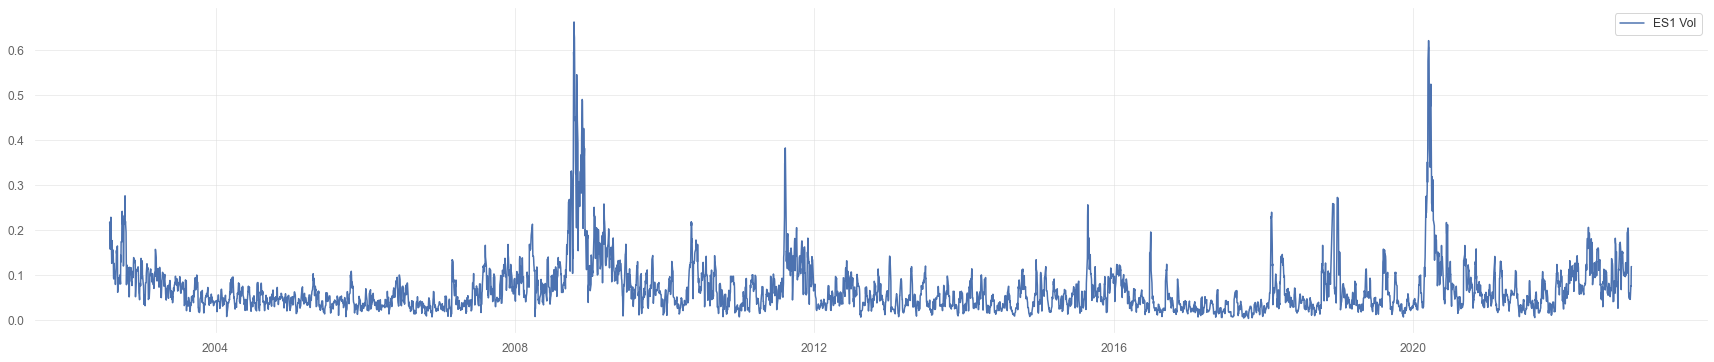

In [142]:
plt.rcParams["figure.figsize"] = (30,6)
plt.plot(vols_total['ES1 Index_Ann_Vol'], label = 'ES1 Vol')
plt.legend()

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
sns.heatmap(vols_total.corr(),
        xticklabels=vols_total.columns,
        yticklabels=vols_total.columns,
        cmap = 'Blues')

<AxesSubplot:xlabel='ticker', ylabel='ticker'>

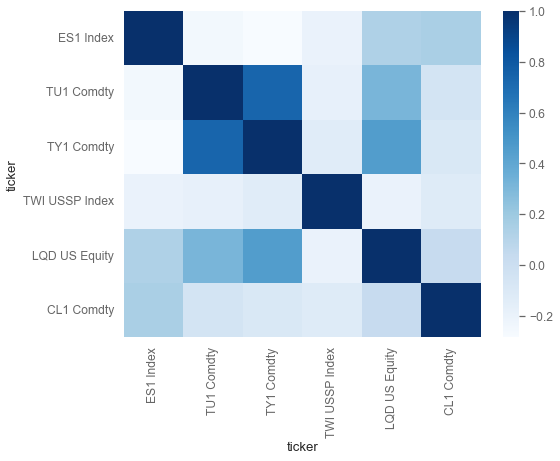

In [66]:
plt.rcParams["figure.figsize"] = (8,6)
sns.heatmap(returns.corr(),
        xticklabels=returns.columns,
        yticklabels=returns.columns,
        cmap = 'Blues')

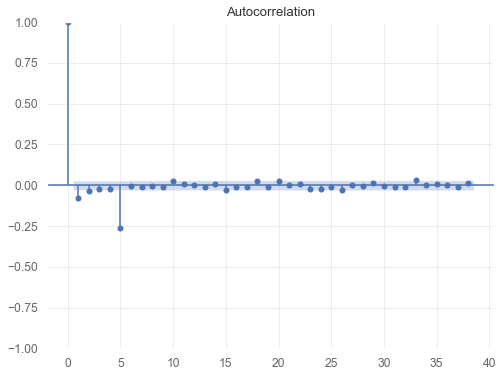

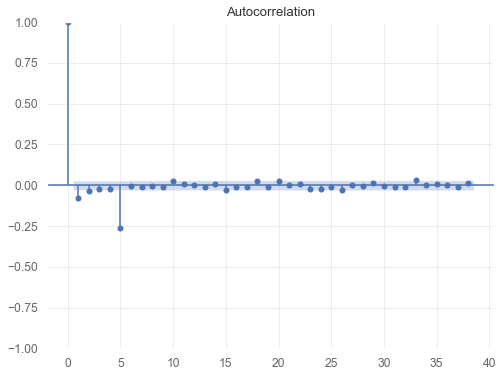

In [15]:
sm.graphics.tsa.plot_acf(vols['ES1 Index_Ann_Vol_Chg'])

In [16]:
from statsmodels.tsa.stattools import adfuller

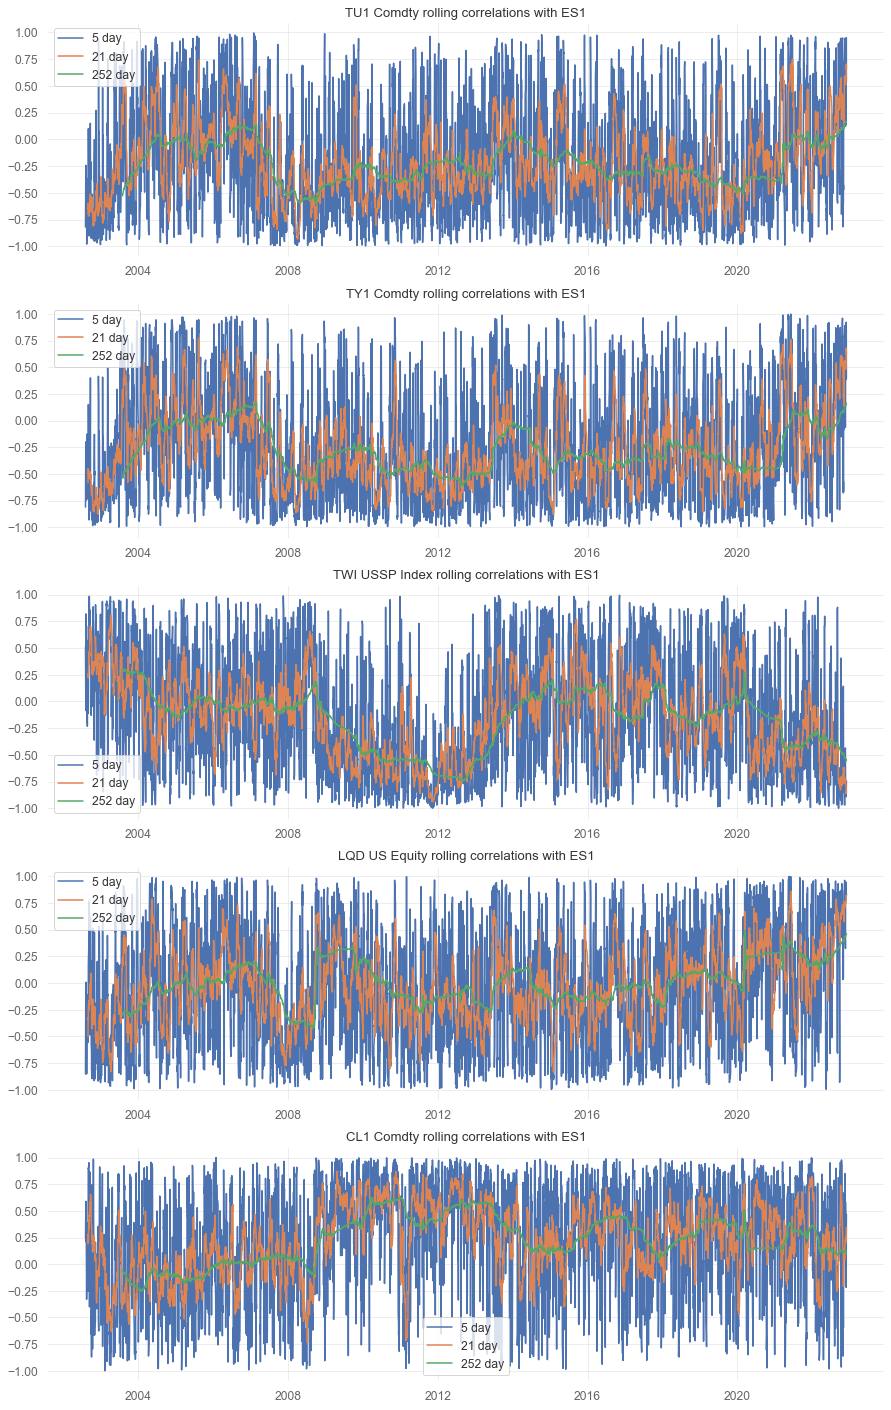

In [210]:
fig, axarr = plt.subplots(int(len(vars)-1),1, figsize=(15,25))
i=0
for x in vars[1:]:
    axarr[i].plot(corrs_w[x +"_corr_w"],label="5 day")
    axarr[i].plot(corrs_m[x +"_corr_m"],label="21 day")
    axarr[i].plot(corrs_y[x +"_corr_y"],label="252 day")
    axarr[i].legend()
    axarr[i].set_title(str(x) + " rolling correlations with ES1")
    i+=1

<AxesSubplot:>

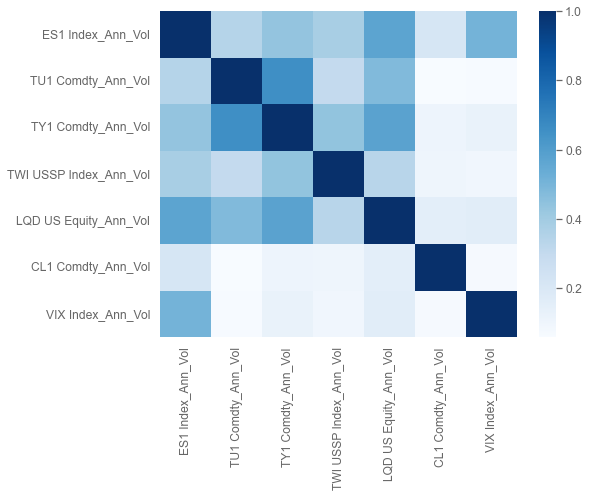

In [20]:
sns.heatmap(vols_total.corr(),
        xticklabels=vols_total.columns,
        yticklabels=vols_total.columns,
        cmap = 'Blues')

<AxesSubplot:>

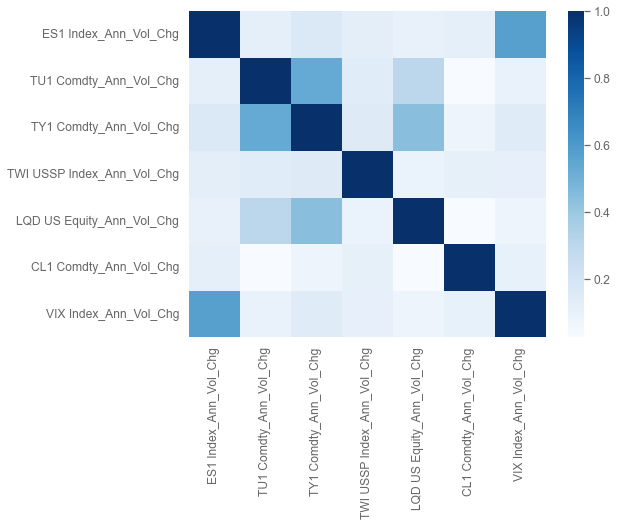

In [21]:
sns.heatmap(vols.corr(),
        xticklabels=vols.columns,
        yticklabels=vols.columns,
        cmap = 'Blues')

In [67]:
vols_standard = vols_total.rolling(252).apply(lambda x: sc.zscore(x)[-1])

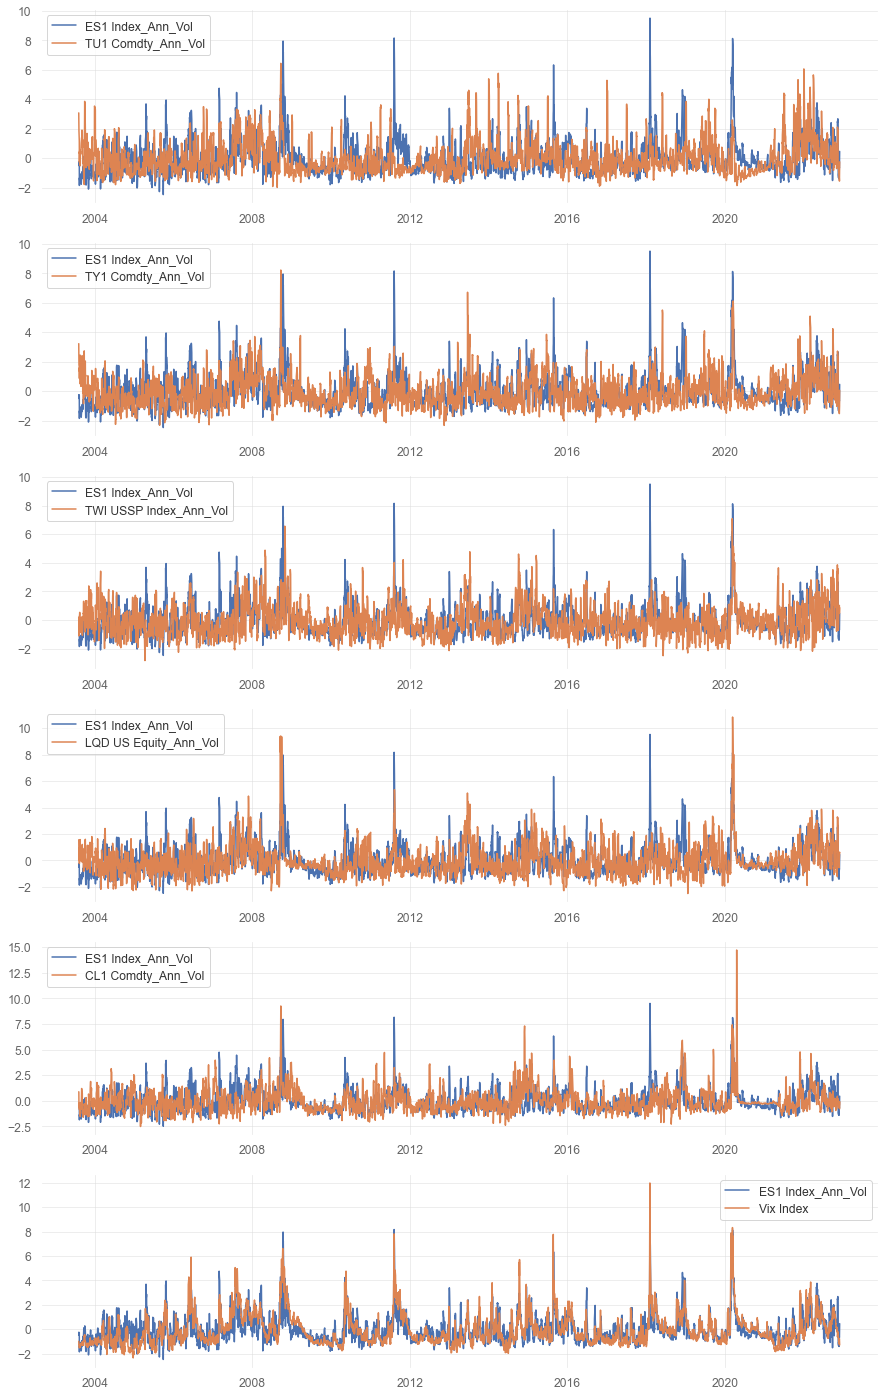

In [68]:
fig, axarr = plt.subplots(int(len(vols_total.columns))-1,1, figsize=(15,25))
i=0
for x in vols_total.columns.tolist()[1:]:
        temp_df = vols_standard[["ES1 Index_Ann_Vol", x]]
        axarr[i].plot(temp_df, label = temp_df.columns)
        axarr[i].legend()
        i+=1

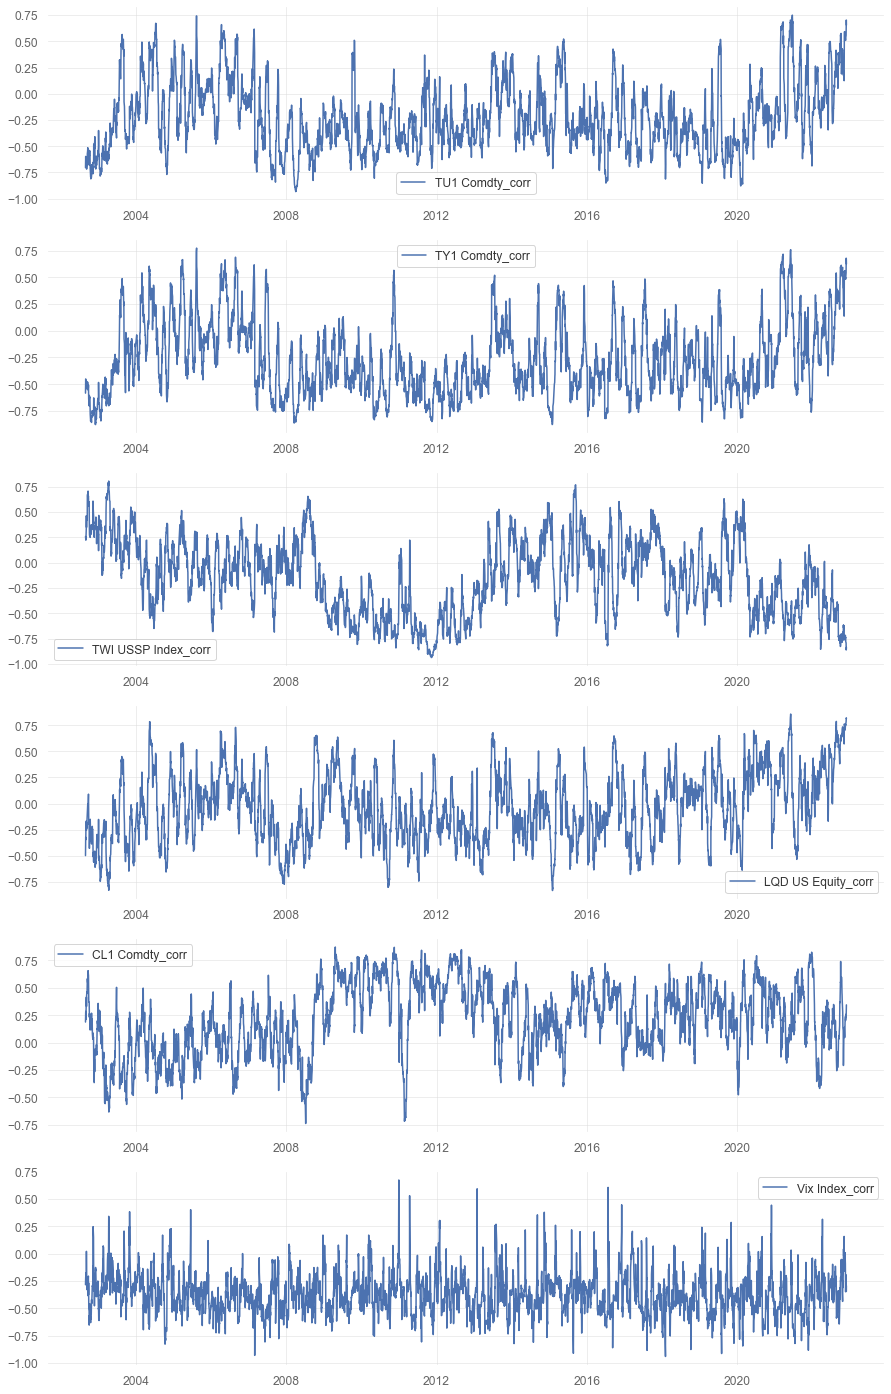

In [69]:
fig, axarr = plt.subplots(int(len(vols_total.columns))-1,1, figsize=(15,25))
i=0
for x in corrs.columns.tolist():
        axarr[i].plot(corrs[x], label = x)
        axarr[i].legend()
        i+=1

#### Modeling

In [9]:
split_date = '20200101'

In [10]:
mod =sm.OLS(vols_total['ES1 Index_Ann_Vol'].loc[:split_date], vols_total.drop(columns=["ES1 Index_Ann_Vol"]).loc[:split_date])
res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:      ES1 Index_Ann_Vol   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                              3837.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):                        0.00
Time:                        14:03:00   Log-Likelihood:                          8531.7
No. Observations:                4344   AIC:                                 -1.705e+04
Df Residuals:                    4338   BIC:                                 -1.701e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [11]:
mod =sm.OLS(vols_total['ES1 Index_Ann_Vol'].loc[:split_date], vols_ewm.loc[vols_total.index].loc[:split_date])
res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:      ES1 Index_Ann_Vol   R-squared (uncentered):                   0.916
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              6786.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):                        0.00
Time:                        14:03:04   Log-Likelihood:                          9920.5
No. Observations:                4344   AIC:                                 -1.983e+04
Df Residuals:                    4337   BIC:                                 -1.978e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

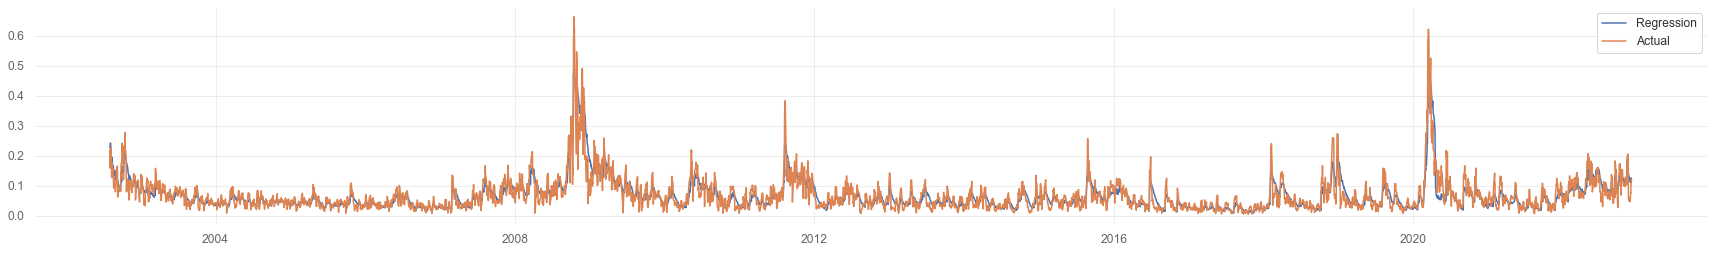

In [12]:
preds =res.predict(vols_ewm.loc[vols_total.index])
plt.rcParams["figure.figsize"] = (30,4)
plt.plot(preds, label="Regression")
plt.plot(vols_total['ES1 Index_Ann_Vol'], label="Actual")
plt.legend()

In [13]:
sklearn.metrics.r2_score(vols_total['ES1 Index_Ann_Vol'].loc[:split_date], preds.loc[:split_date])

0.7968185149886164

In [14]:
sklearn.metrics.r2_score(vols_total['ES1 Index_Ann_Vol'].loc[split_date:], preds.loc[split_date:])

0.7607996256857757

In [15]:
mod =sm.OLS(vols_total['ES1 Index_Ann_Vol'].loc[:split_date].iloc[5:], vols_ewm.loc[vols_total.index].loc[:split_date].shift(5).iloc[5:])
res_lag_1 = mod.fit()

print(res_lag_1.summary())

                                 OLS Regression Results                                
Dep. Variable:      ES1 Index_Ann_Vol   R-squared (uncentered):                   0.820
Model:                            OLS   Adj. R-squared (uncentered):              0.820
Method:                 Least Squares   F-statistic:                              2816.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):                        0.00
Time:                        14:11:16   Log-Likelihood:                          8257.0
No. Observations:                4339   AIC:                                 -1.650e+04
Df Residuals:                    4332   BIC:                                 -1.646e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

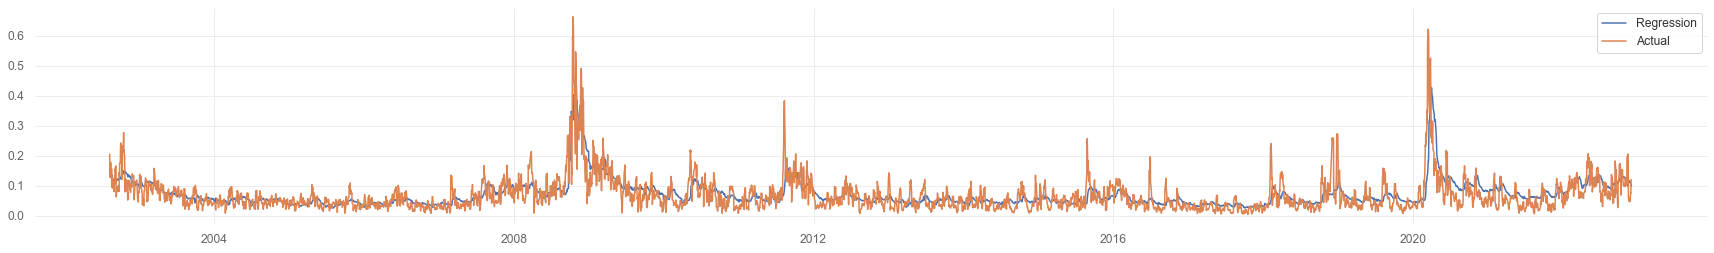

In [16]:
preds =res_lag_1.predict(vols_ewm.loc[vols_total.index].shift(5).iloc[5:])
plt.plot(preds, label="Regression")
plt.plot(vols_total['ES1 Index_Ann_Vol'].iloc[5:], label="Actual")
plt.rcParams["figure.figsize"] = (30,4)
plt.legend()

In [17]:
sklearn.metrics.r2_score(vols_total['ES1 Index_Ann_Vol'].loc[split_date:], preds.loc[split_date:])

0.37314187166364

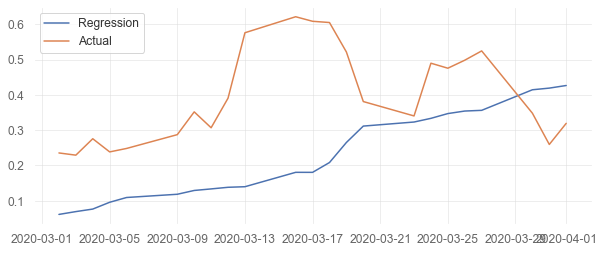

In [18]:
plt.rcParams["figure.figsize"] = (64)
plt.plot(preds.loc['20200301':'20200415'], label="Regression")
plt.plot(vols_total['ES1 Index_Ann_Vol'].loc['20200301':'20200415'], label="Actual")
plt.legend()

#### XGBRegressor

In [19]:
import xgboost as xgb

C:\Users\evank\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [102]:
xg = xgb.XGBRegressor(learning_rate=.01,n_estimators=500, max_depth=2)
xg.fit(vols_ewm.loc[vols_total.index].loc[:split_date].shift(5).iloc[5:],vols_total['ES1 Index_Ann_Vol'].loc[:split_date].iloc[5:])

C:\Users\evank\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

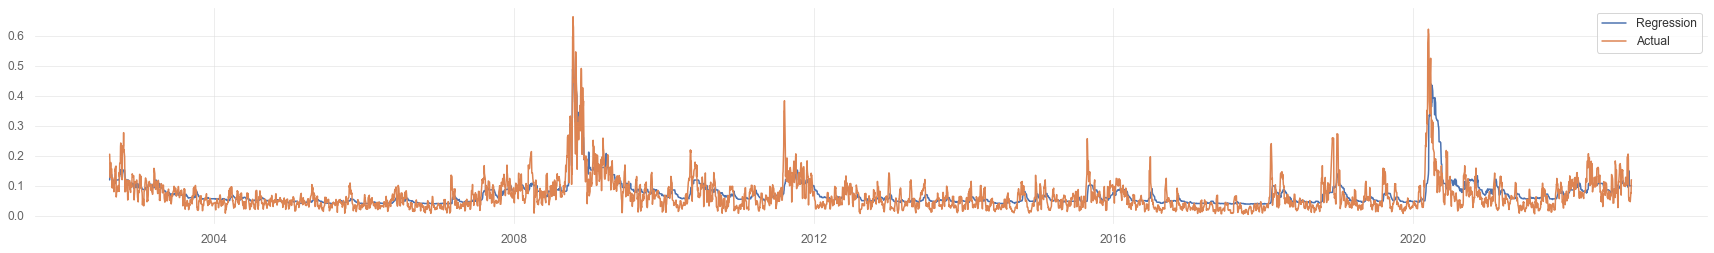

In [103]:
plt.rcParams["figure.figsize"] = (30,4)
preds_xg = pd.DataFrame(index= vols_total.index[5:])
preds_xg['Preds'] =xg.predict(vols_ewm.loc[vols_total.index].shift(5).iloc[5:])
plt.plot(preds_xg, label="Regression")
plt.plot(vols_total['ES1 Index_Ann_Vol'].iloc[5:], label="Actual")

plt.legend()

In [104]:
sklearn.metrics.r2_score(vols_total['ES1 Index_Ann_Vol'].loc[split_date:], preds_xg.loc[split_date:])

0.25318607598653364

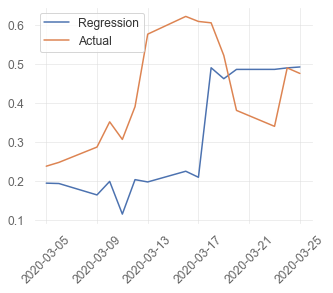

In [189]:
plt.rcParams["figure.figsize"] = (5,4)
plt.plot(preds_xg.loc['20200305':'20200325'], label="Regression")
plt.plot(vols_total['ES1 Index_Ann_Vol'].loc['20200305':'20200325'], label="Actual")
plt.xticks(rotation=45)
plt.legend()

<BarContainer object of 7 artists>

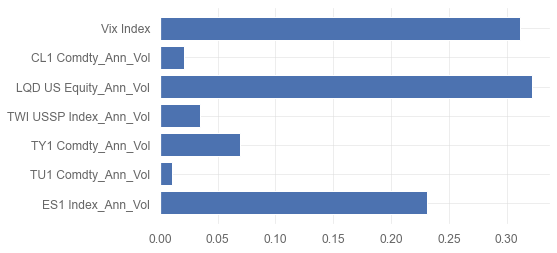

In [106]:
plt.rcParams["figure.figsize"] = (7,4)
plt.barh(vols_ewm.columns,xg.feature_importances_)

#### XGB with Correlation Features Rolling

In [20]:
import optuna

C:\Users\evank\anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
features = vols_ewm.join(corrs_y).join(corrs_w).join(corrs_m)
features = features.dropna()
vols_total_xg = vols_total.loc[features.index[0]:]

In [58]:
def objective(trial, valid_date, split_date):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
    }
    train_length = trial.suggest_int("train_length", 50,len(features.loc[:valid_date]))

    n_features=features.loc[:valid_date].iloc[-train_length:]
    n_vols_total_xg = vols_total_xg.loc[:valid_date].iloc[-train_length:]
    x_train, y_train = n_features.loc[:valid_date].shift(5).iloc[5:], n_vols_total_xg['ES1 Index_Ann_Vol'].loc[:valid_date].iloc[5:]
    x_val,y_val = features.loc[valid_date:split_date].shift(5).iloc[5:], vols_total_xg['ES1 Index_Ann_Vol'].loc[valid_date:split_date].iloc[5:]
    xg = xgb.XGBRegressor(**params)
    xg.fit(x_train,y_train)
    y_pred = xg.predict(x_val)
    r2= sklearn.metrics.r2_score(y_val, y_pred)

    return r2

In [59]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [68]:
preds=[]
train_length_list=[]
feat_import_list = []
start_date = '20150101'
last_date = '20150101'

In [73]:
for split_date in features.loc[last_date:].iloc[1:].index:
    v_date = split_date - dt.timedelta(days=21)
    func = lambda trial: objective(trial, v_date,split_date)
    study = optuna.create_study(direction="maximize")
    study.optimize(func, n_trials=30)
    train_l = study.best_params['train_length']
    params = study.best_params
    del params['train_length']
    xg = xgb.XGBRegressor(**params)
    xg.fit(features.loc[:split_date].shift(5).iloc[-train_l-15:-1],vols_total_xg['ES1 Index_Ann_Vol'].loc[:split_date].iloc[-train_l-15:-1])
    preds.append(xg.predict(pd.DataFrame(features.loc[:split_date].shift(5).iloc[-1]).T)[0])
    last_date = split_date
    print(str(split_date) + " " + str(dt.datetime.now()))
    train_length_list.append(train_l)
    feat_import_list.append(xg.feature_importances_)

2016-11-16 00:00:00 2022-12-04 22:26:09.460253
2016-11-17 00:00:00 2022-12-04 22:26:19.807604
2016-11-18 00:00:00 2022-12-04 22:26:33.237091
2016-11-21 00:00:00 2022-12-04 22:26:40.510958
2016-11-22 00:00:00 2022-12-04 22:26:56.580427
2016-11-23 00:00:00 2022-12-04 22:27:09.852264
2016-11-25 00:00:00 2022-12-04 22:27:24.570998
2016-11-28 00:00:00 2022-12-04 22:27:32.307239
2016-11-29 00:00:00 2022-12-04 22:27:43.298445
2016-11-30 00:00:00 2022-12-04 22:27:51.673085
2016-12-01 00:00:00 2022-12-04 22:28:04.289151
2016-12-02 00:00:00 2022-12-04 22:28:12.306135
2016-12-05 00:00:00 2022-12-04 22:28:23.907944
2016-12-06 00:00:00 2022-12-04 22:28:34.144204
2016-12-07 00:00:00 2022-12-04 22:28:43.678529
2016-12-08 00:00:00 2022-12-04 22:28:51.839201
2016-12-09 00:00:00 2022-12-04 22:29:03.474610
2016-12-12 00:00:00 2022-12-04 22:29:14.101677
2016-12-13 00:00:00 2022-12-04 22:29:24.159181
2016-12-14 00:00:00 2022-12-04 22:29:33.708080
2016-12-15 00:00:00 2022-12-04 22:29:46.252140
2016-12-16 00

In [79]:
feat_import_list

[array([0.06973484, 0.00980185, 0.01518309, 0.00611356, 0.40025872,
        0.11470004, 0.10191318, 0.05631298, 0.01986583, 0.01081119,
        0.01852343, 0.00991916, 0.05883295, 0.00705334, 0.00858003,
        0.00597504, 0.00375334, 0.00959079, 0.00438826, 0.01320862,
        0.01038186, 0.00827065, 0.00745249, 0.0214559 , 0.00791879],
       dtype=float32),
 array([6.3148119e-02, 9.9445218e-03, 1.4662150e-02, 2.7617754e-03,
        7.0160949e-03, 8.4174117e-03, 6.6688307e-02, 6.4154071e-01,
        1.4430394e-02, 5.2780458e-03, 3.0368540e-02, 3.4370206e-03,
        4.6871725e-02, 3.5534631e-03, 6.2166834e-03, 6.5828450e-03,
        3.3054082e-03, 3.3009902e-03, 5.4473808e-04, 8.0641313e-03,
        4.8099137e-03, 2.6693802e-02, 5.6094965e-03, 1.4257046e-02,
        2.4966437e-03], dtype=float32),
 array([0.08445635, 0.01160465, 0.013091  , 0.00826832, 0.42505893,
        0.10520528, 0.08049074, 0.04118272, 0.02171934, 0.01420953,
        0.01905907, 0.01155972, 0.05422341, 0.006583

<AxesSubplot:xlabel='date'>

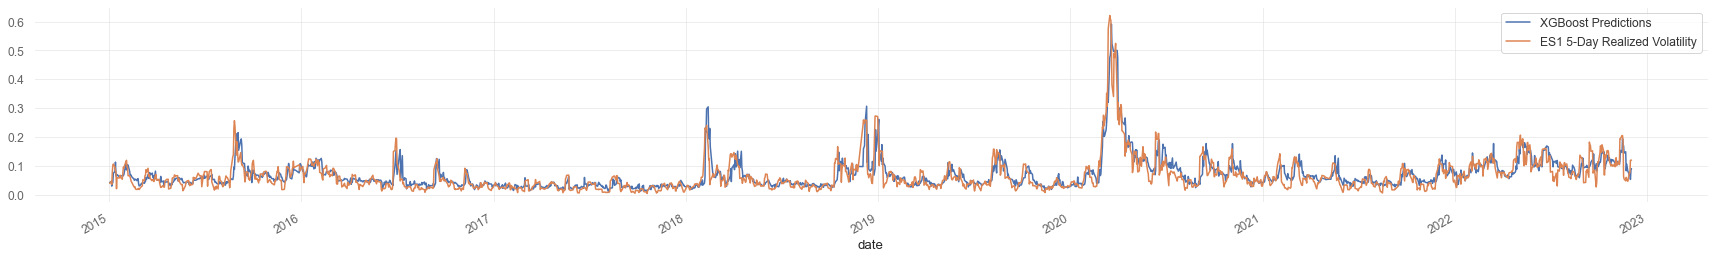

In [76]:
plt.rcParams["figure.figsize"] = (30,4)
vol_forecast_5day = pd.DataFrame(index=features.loc[start_date:last_date].index)
vol_forecast_5day['XGBoost Predictions'] = preds
vol_forecast_5day['ES1 5-Day Realized Volatility'] = vols_total_xg['ES1 Index_Ann_Vol']
vol_forecast_5day.plot()

In [77]:
sklearn.metrics.r2_score(vol_forecast_5day['ES1 5-Day Realized Volatility'], vol_forecast_5day['XGBoost Predictions'])

0.73153556125096

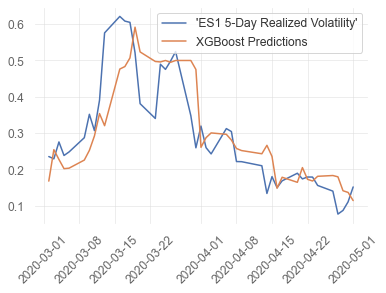

In [78]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(vol_forecast_5day['ES1 5-Day Realized Volatility'].loc['20200301':'20200501'], label="'ES1 5-Day Realized Volatility'")
plt.plot(vol_forecast_5day['XGBoost Predictions'].loc['20200301':'20200501'], label="XGBoost Predictions")
plt.xticks(rotation=45)
plt.legend()

<Figure size 432x288 with 0 Axes>

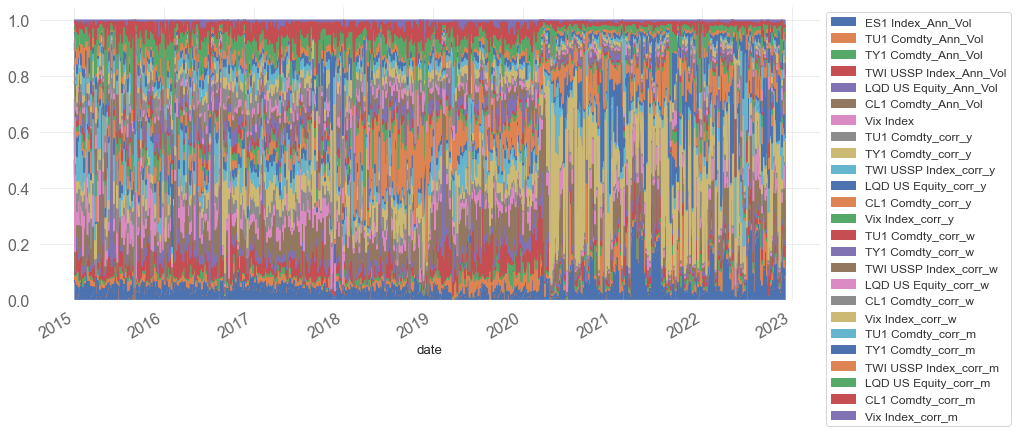

In [81]:
plt.clf()
feature_importance_df = pd.DataFrame(feat_import_list, index = vol_forecast_5day.index, columns = features.columns )
feature_importance_df.plot.area(fontsize=16)

plt.gcf().set_size_inches(14,6)
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

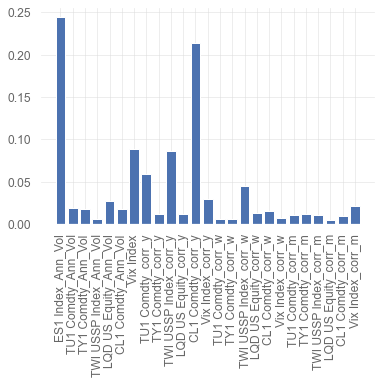

In [83]:
plt.bar(features.columns.tolist(),xg.feature_importances_)
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Optimal Training Length Throughout Rolling Model')

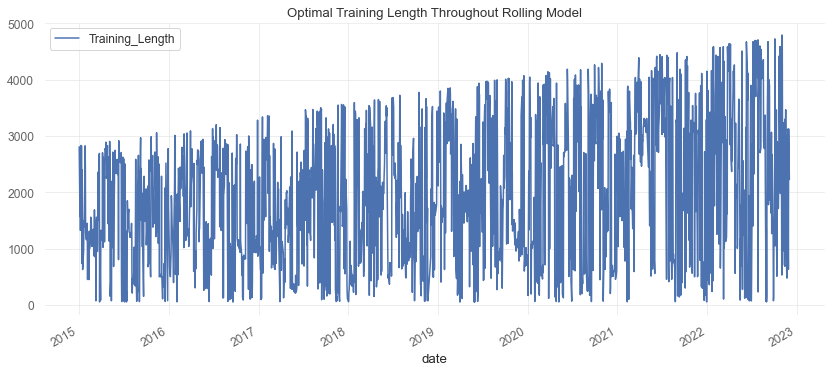

In [87]:
tl =pd.DataFrame(index=vol_forecast_5day.index)
tl['Training_Length'] = train_length_list
tl.plot()
plt.gcf().set_size_inches(14,6)
plt.title("Optimal Training Length Throughout Rolling Model")